In [142]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
import random
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [143]:
source_db = {
    'servername': r'LAPTOP-NDOACQTH\SQLEXPRESS',
    'database': 'DWUnitedOutdoors'
}

source_conn_str = (
    'Driver={SQL Server};'
    'SERVER=' + source_db['servername'] + ';'
    'DATABASE=' + source_db['database'] + ';'
    'Trusted_Connection=yes;'
)

In [144]:
try:
    with pyodbc.connect(source_conn_str) as source_conn:
        product_df = pd.read_sql_query("SELECT ProductID, ListPrice, StandardCost FROM dbo.ProductionProduct", source_conn)
        sales_order_df = pd.read_sql_query("SELECT SalesOrderDetailID, OrderQty, ProductID, UnitPrice, LineTotal, AverageRate, Freight, TaxAmt, SubTotal FROM dbo.Sales_Order", source_conn)  # Removed extra comma here
        sales_df = pd.merge(sales_order_df, product_df, on='ProductID', how='left')
except pyodbc.Error as e:
    print("Error while connecting to the source SQL Server:", e)
sales_df

,SalesOrderDetailID,OrderQty,ProductID,UnitPrice,LineTotal,AverageRate,Freight,TaxAmt,SubTotal,ListPrice,StandardCost
0,32,2,730,183.9382,367.8764,1.4641,867.2389,2775.1646,28832.5289,337.22,187.1571
1,64,2,715,28.8404,57.6808,0.0000,429.9821,1375.9427,14352.7713,49.99,38.4923
2,96,2,764,419.4589,838.9178,1.4641,1081.8017,3461.7654,35944.1562,782.99,486.7066
3,128,1,774,2039.9940,2039.9940,1.4641,183.6257,587.6023,6124.1820,3399.99,1912.1544
4,160,4,760,419.4589,1677.8356,1.4641,233.4691,747.1011,7793.1108,782.99,486.7066
...,...,...,...,...,...,...,...,...,...,...,...
121312,121313,1,878,21.9800,21.9800,0.0000,0.7743,2.4776,30.9700,21.98,8.2205
121313,121314,1,712,8.9900,8.9900,0.0000,0.7743,2.4776,30.9700,8.99,6.9223
121314,121315,1,878,21.9800,21.9800,0.0000,4.7493,15.1976,189.9700,21.98,8.2205
121315,121316,1,879,159.0000,159.0000,0.0000,4.7493,15.1976,189.9700,159.00,59.4660


In [145]:
x = sales_df.drop('ListPrice', axis=1)
y = sales_df.loc[:, 'ListPrice']
x

,SalesOrderDetailID,OrderQty,ProductID,UnitPrice,LineTotal,AverageRate,Freight,TaxAmt,SubTotal,StandardCost
0,32,2,730,183.9382,367.8764,1.4641,867.2389,2775.1646,28832.5289,187.1571
1,64,2,715,28.8404,57.6808,0.0000,429.9821,1375.9427,14352.7713,38.4923
2,96,2,764,419.4589,838.9178,1.4641,1081.8017,3461.7654,35944.1562,486.7066
3,128,1,774,2039.9940,2039.9940,1.4641,183.6257,587.6023,6124.1820,1912.1544
4,160,4,760,419.4589,1677.8356,1.4641,233.4691,747.1011,7793.1108,486.7066
...,...,...,...,...,...,...,...,...,...,...
121312,121313,1,878,21.9800,21.9800,0.0000,0.7743,2.4776,30.9700,8.2205
121313,121314,1,712,8.9900,8.9900,0.0000,0.7743,2.4776,30.9700,6.9223
121314,121315,1,878,21.9800,21.9800,0.0000,4.7493,15.1976,189.9700,8.2205
121315,121316,1,879,159.0000,159.0000,0.0000,4.7493,15.1976,189.9700,59.4660


In [146]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.15,
    random_state=42
)

In [147]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train, y_train)
reg_model

LinearRegression()

In [148]:
y_pred = reg_model.predict(x_test)
y_pred

array([  22.73564492,   15.10435175, 2104.97502781, ..., 1219.4534082 ,
       1003.88568845,   19.84874221])

In [149]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0 : 'Predicted_ListPrice'})
prediction_df

,Predicted_ListPrice
0,22.735645
1,15.104352
2,2104.975028
3,5.412888
4,6.682942
...,...
18193,354.207029
18194,10.228439
18195,1219.453408
18196,1003.885688


In [150]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['ListPrice'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_ListPrice'].notna(), :]

,ListPrice,Predicted_ListPrice
0,24.49,22.735645
1,4.99,15.104352
2,2319.99,2104.975028
3,2.29,5.412888
4,24.49,6.682942
...,...,...
18193,337.22,354.207029
18194,2.29,10.228439
18195,1120.49,1219.453408
18196,1003.91,1003.885688


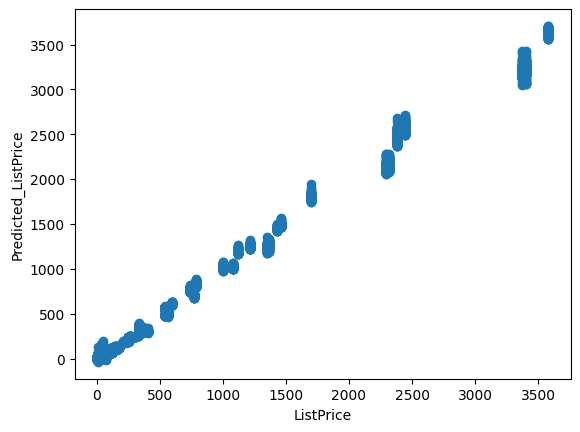

In [151]:
plt.scatter(y_test_prediction_merge['ListPrice'], y_test_prediction_merge['Predicted_ListPrice'])
plt.xlabel('ListPrice')
plt.ylabel('Predicted_ListPrice')
plt.show()

In [152]:
mean_squared_error(y_test_prediction_merge['ListPrice'], y_test_prediction_merge['Predicted_ListPrice'])

4371.82256141326

In [153]:
totalUnitSalePrice = y_test_prediction_merge['ListPrice'].sum()
totalUnitSalePrice

11691852.93

In [154]:
totalPredictedUnitSalePrice = y_test_prediction_merge['Predicted_ListPrice'].sum()
totalPredictedUnitSalePrice

11686698.944206022

In [155]:
try:
    with pyodbc.connect(source_conn_str) as source_conn:
        product_df = pd.read_sql_query("SELECT ProductID, UnitsInStock, UnitsOnOrder, ReOrderLevel, Discontinued  FROM dbo.Product", source_conn)
        sales_order_df = pd.read_sql_query("SELECT OrderID, ProductID, Quantity, Discount, UnitPrice FROM dbo.Orders", source_conn)  # Removed extra comma here
        sales_df = pd.merge(sales_order_df, product_df, on='ProductID', how='left')
except pyodbc.Error as e:
    print("Error while connecting to the source SQL Server:", e)
sales_df

,OrderID,ProductID,Quantity,Discount,UnitPrice,UnitsInStock,UnitsOnOrder,ReOrderLevel,Discontinued
0,10260,57,50,0.00,15.60,36,0,20,False
1,10275,59,6,0.05,44.00,79,0,0,False
2,10289,3,30,0.00,8.00,13,70,25,False
3,10302,17,40,0.00,31.20,0,0,0,True
4,10315,34,14,0.00,11.20,111,0,15,False
...,...,...,...,...,...,...,...,...,...
2150,11077,64,2,0.03,33.25,22,80,30,False
2151,11077,66,1,0.00,17.00,4,100,20,False
2152,11077,73,2,0.01,15.00,101,0,5,False
2153,11077,75,4,0.00,7.75,125,0,25,False


In [158]:
sales_df['Discontinued'] = sales_df['Discontinued'].astype(int)
features = ['Quantity', 'Discount', 'UnitsInStock', 'UnitsOnOrder', 'ReOrderLevel', 'Discontinued']
X = sales_df[features]
y = sales_df['UnitPrice']

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [162]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [165]:
y_pred = reg_model.predict(X_test)

In [166]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0 : 'Predicted_UnitPrice'})
prediction_df

,Predicted_UnitPrice
0,26.111523
1,31.906517
2,12.243211
3,17.001351
4,39.684709
...,...
319,31.197244
320,26.053794
321,30.785772
322,35.408512


In [167]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['UnitPrice'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_UnitPrice'].notna(), :]

,UnitPrice,Predicted_UnitPrice
0,22.00,26.111523
1,7.45,31.906517
2,7.75,12.243211
3,16.00,17.001351
4,123.79,39.684709
...,...,...
319,28.80,31.197244
320,22.00,26.053794
321,13.90,30.785772
322,45.60,35.408512


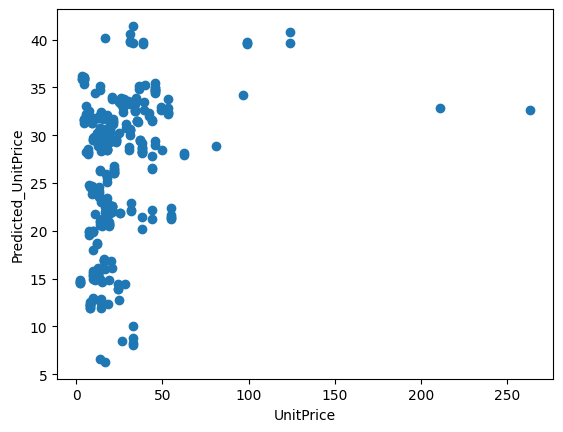

In [168]:
plt.scatter(y_test_prediction_merge['UnitPrice'], y_test_prediction_merge['Predicted_UnitPrice'])
plt.xlabel('UnitPrice')
plt.ylabel('Predicted_UnitPrice')
plt.show()

In [169]:
mean_squared_error(y_test_prediction_merge['UnitPrice'], y_test_prediction_merge['Predicted_UnitPrice'])

566.441986770467